## Import required libraries

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.decomposition import PCA
sns.set()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# path to drive
datasets_path = os.path.join('drive', 'My Drive', 'ost-sm-2020')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load features, and labels saved in npy format

In [4]:
X = np.load( os.path.join(datasets_path, 'non_vpn_ds.npy') ).astype(np.float32)
Y = np.load( os.path.join(datasets_path, 'non_vpn_top_annotations.npy'),allow_pickle=True )

print( X.shape )

(131065, 121)


## encode the labels

In [5]:
# encode labels
lbl_encoder = LabelEncoder()

y_encoded = lbl_encoder.fit_transform(Y)

## Standardize the data set ----> remove mean and re-scale the variance to unit vector

In [6]:
standard_scaler = StandardScaler()

x_scaled = standard_scaler.fit_transform(X)

## create a dictionary that maps from encoded labels to their corresponding text

In [16]:
labels_encoded = np.unique(y_encoded)
n_classes = len( labels_encoded )
lables_text = lbl_encoder.inverse_transform( np.arange(0, n_classes, 1) )

number_to_text = { labels_encoded[i]:lables_text[i] for i in range(n_classes)}

print(number_to_text)

{0: 'P2P', 1: 'audio', 2: 'chat', 3: 'email', 4: 'file_transfer', 5: 'tor', 6: 'video'}


## Data Visualization using Principal Component Analysis

### perform Principal Component Analysis to obtain the first 3 principal components

In [24]:
pca = PCA()

pca.n_components = 3

pca_data = pca.fit_transform( x_scaled )

## Attaching label to each n-d point
pca_data = np.vstack( (pca_data.T, y_encoded) ).T

print(pca_data.shape)

(131065, 4)


## Visualization part

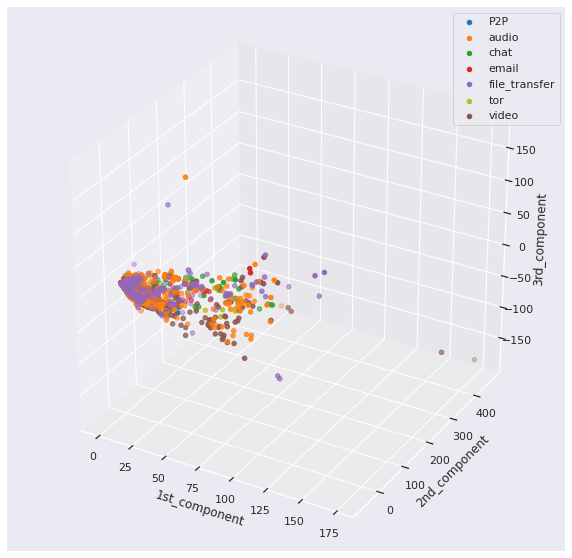

In [33]:
cols = ['1st_component', '2nd_component','3rd_component', 'label']
pca_df = pd.DataFrame(data=pca_data, columns=cols)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("1st_component")
ax.set_ylabel("2nd_component")
ax.set_zlabel("3rd_component")

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive','tab:brown']

for category in range( 7 ):

  category_df = pca_df[pca_df['label']==category]

  x = category_df['1st_component']
  y = category_df['2nd_component']
  z = category_df['3rd_component']
  ax.scatter3D(x, y, z,c=colors[category])
plt.legend(lables_text)
plt.show()
# sns.FacetGrid(pca_df, hue='label', size=6).map(plt.scatter, '1st_component', '2nd_component').add_legend()
# plt.show()

## Split the data into 80% Train and 20% Test

In [15]:
# split into 80% train, and 20% test

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, shuffle=True)

## Logistic Regression with parameters: C (regularization strength) = 1.0, solver = 'lbfgs', max iterations for optimization algorithm = 3000

In [18]:
lr = LogisticRegression(max_iter=3000)

lr_scores = cross_validate(
    lr,
    x_train,
    y_train,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    return_estimator=True
)

print( 'best cross-validation score = {}'.format( max( lr_scores['test_score'] ) ) )

best cross-validation score = 0.6998569384835479


## Extract the best estimator and print different metrics for the test set

accuracy = 0.7017128905504902

Recall for P2P = 0.3048128342245989, and precision = 0.4418604651162791
Recall for audio = 0.9884962571554381, and precision = 0.7069637444396332
Recall for chat = 0.03827751196172249, and precision = 0.48
Recall for email = 0.049586776859504134, and precision = 0.6461538461538462
Recall for file_transfer = 0.012197521148927798, and precision = 0.5
Recall for tor = 0.047619047619047616, and precision = 0.16666666666666666
Recall for video = 0.3445635528330781, and precision = 0.582901554404145



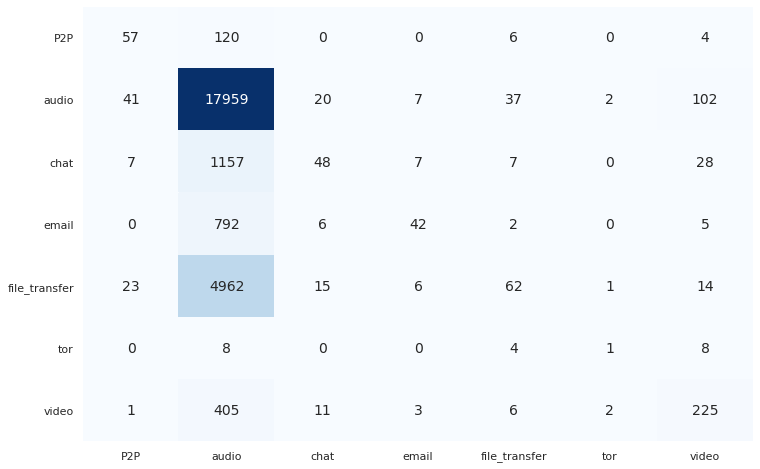

In [35]:
# print different metrics for the test set

# scores ----> accuracy, recall, precision, confusion matrix

best_estimator_ = lr_scores['estimator'][np.argmax( lr_scores['test_score'] )]

y_pred = best_estimator_.predict( x_test )

# recall: model's ability to detect all positive examples
recall = recall_score(y_test, y_pred, average=None)

# precision: model's ability not to classifiy as positive a negative sample
precision = precision_score(y_test, y_pred, average=None)

# accuracy
print( 'accuracy = {}\n'.format( accuracy_score( y_test, y_pred ) ) )

for i in range(n_classes):
  label = number_to_text[i]
  class_recall = recall[i]
  class_precision = precision[i]

  print('Recall for {} = {}, and precision = {}{}'.format(label, class_recall, class_precision,'\n' * ((i+1) // n_classes)))

# Create a new axes
plt.figure(figsize=(12,8))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=best_estimator_.classes_)

# Createa a heatmap for the Confusion Matrix
sns.heatmap(cm,
            annot=True,
            xticklabels=lables_text,
            yticklabels=lables_text,
            fmt='d',
            cmap=plt.cm.Blues,
            annot_kws={"size": 14},
            cbar=False)

## Run GridSearch with 5-Fold Cross validation on a Decision Tree Classifier

In [8]:
# Decision Tree Validation acc = 0.727

dt = DecisionTreeClassifier()

gridSearchDT = GridSearchCV(estimator=dt,
            param_grid={'max_depth':list(range(2,31))},
        cv=StratifiedKFold(n_splits=5),
      scoring='accuracy')

gridSearchDT.fit(x_train, y_train)

print( 'best cross-validation score = {}'.format( gridSearchDT.best_score_ ) )
print( 'best params', gridSearchDT.best_params_ )

best cross-validation score = 0.7285888646962503
best params {'max_depth': 18}


accuracy = 0.7293327738145196

Recall for P2P = 0.7272727272727273, and precision = 0.8662420382165605
Recall for audio = 0.9771985167967236, and precision = 0.7305034959248686
Recall for chat = 0.3205629397967162, and precision = 0.8282828282828283
Recall for email = 0.30599755201958384, and precision = 0.7668711656441718
Recall for file_transfer = 0.06142884652416715, and precision = 0.5576923076923077
Recall for tor = 0.5, and precision = 0.41379310344827586
Recall for video = 0.5186335403726708, and precision = 0.7213822894168467



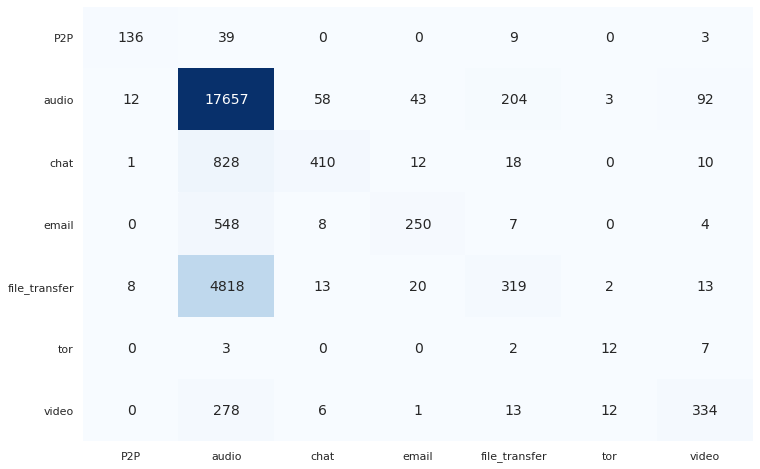

In [36]:
# print different metrics for the test set

# scores ----> accuracy, recall, precision, roc_auc, confusion matrix

best_estimator_ = gridSearchDT.best_estimator_

y_pred = best_estimator_.predict( x_test )

# recall: model's ability to detect all positive examples
recall = recall_score(y_test, y_pred, average=None)

# precision: model's ability not to classifiy as positive a negative sample
precision = precision_score(y_test, y_pred, average=None)

# accuracy
print( 'accuracy = {}\n'.format( accuracy_score( y_test, y_pred ) ) )

for i in range(n_classes):
  label = number_to_text[i]
  class_recall = recall[i]
  class_precision = precision[i]

  print('Recall for {} = {}, and precision = {}{}'.format(label, class_recall, class_precision,'\n' * ((i+1) // n_classes)))

# Create a new axes
plt.figure(figsize=(12,8))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=best_estimator_.classes_)

# Createa a heatmap for the Confusion Matrix
sns.heatmap(cm,
            annot=True,
            xticklabels=lables_text,
            yticklabels=lables_text,
            fmt='d',
            cmap=plt.cm.Blues,
            annot_kws={"size": 14},
            cbar=False)

## Run Grid Search with 5-Fold Cross validation on a Random Forest Classifier

In [8]:
rf = RandomForestClassifier()

gridSearchRF = GridSearchCV(
    rf, param_grid={
        'n_estimators': list( range(5, 51, 5)),
        'max_depth': list(range(1, 21))
    }, scoring='accuracy', cv=StratifiedKFold(n_splits=5))

gridSearchRF.fit(x_scaled, y_encoded)

print( 'best cross-validation score = {}'.format( gridSearchRF.best_score_ ) )
print( 'best params', gridSearchRF.best_params_ )

best cross-validation score = 0.732316026399115
best params {'max_depth': 20, 'n_estimators': 30}


accuracy = 0.7540533323160264

Recall for P2P = 0.8670886075949367, and precision = 1.0
Recall for audio = 0.9991740542921645, and precision = 0.7385729984940372
Recall for chat = 0.3366255144032922, and precision = 0.9927184466019418
Recall for email = 0.30893300248138955, and precision = 0.9841897233201581
Recall for file_transfer = 0.0664756446991404, and precision = 0.9914529914529915
Recall for tor = 0.8181818181818182, and precision = 1.0
Recall for video = 0.7451298701298701, and precision = 0.9704016913319239



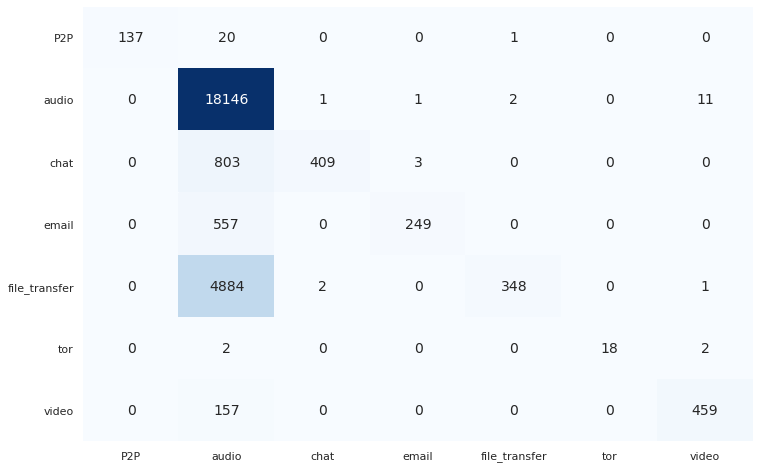

In [9]:
# print different metrics for the test set

# scores ----> accuracy, recall, precision, roc_auc, confusion matrix

best_estimator_ = gridSearchRF.best_estimator_

y_pred = best_estimator_.predict( x_test )

# recall: model's ability to detect all positive examples
recall = recall_score(y_test, y_pred, average=None)

# precision: model's ability not to classifiy as positive a negative sample
precision = precision_score(y_test, y_pred, average=None)

# accuracy
print( 'accuracy = {}\n'.format( accuracy_score( y_test, y_pred ) ) )

for i in range(n_classes):
  label = number_to_text[i]
  class_recall = recall[i]
  class_precision = precision[i]

  print('Recall for {} = {}, and precision = {}{}'.format(label, class_recall, class_precision,'\n' * ((i+1) // n_classes)))

# Create a new axes
plt.figure(figsize=(12,8))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=best_estimator_.classes_)

# Createa a heatmap for the Confusion Matrix
sns.heatmap(cm,
            annot=True,
            xticklabels=lables_text,
            yticklabels=lables_text,
            fmt='d',
            cmap=plt.cm.Blues,
            annot_kws={"size": 14},
            cbar=False)

## Vanilla Generative Adversarial Network

In [10]:
# Normalize dataset to the range [0..1] for Neural Network

normalizer = MinMaxScaler()

normalized_samples = normalizer.fit_transform(X)

In [11]:
# helper function for generating one-hot vectors for labels
def get_one_hot_encoding(indices, depth):

  return tf.one_hot(indices, depth)

In [12]:
# helper for adding one-hot vectors to the input batch
def get_input_with_labels(samples, one_hot_labels):

  return tf.concat([samples, one_hot_labels], axis=1)

In [13]:
# create dataset of batches

def get_batches(buffer_size, batch_size, samples, labels):

  return tf.data.Dataset.from_tensor_slices((samples, labels)).shuffle(buffer_size).batch(batch_size)

In [14]:
# transform the input data into batches --->

BUFFER_SIZE = normalized_samples.shape[0] # the size of dataset, needed for transforming the data set into batches
BATCH_SIZE = 256 # batch size

dataset = get_batches(BUFFER_SIZE, BATCH_SIZE, normalized_samples, y_encoded)

In [15]:
noise_dim = 100 # noise vector size that will be the input to generator
n_classes = len( np.unique(y_encoded) ) # number of classes
gen_input_dim = noise_dim + n_classes # generator input
output_shape = normalized_samples.shape[1] # generator output
disc_input_dim = output_shape + n_classes # discriminator input

In [16]:
# Generator architecture

def generator_model(gen_input_dim, output_shape,hidden_units=128):

  model = tf.keras.Sequential([
                               
      tf.keras.layers.Dense(hidden_units, input_shape = (gen_input_dim,), use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(hidden_units * 2, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(hidden_units * 4, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Dense(output_shape,use_bias=False, activation='sigmoid'),
  ])
      
  return model

## Create a generator model and print a summary of its architecture

In [17]:
generator = generator_model( gen_input_dim, output_shape,hidden_units=64 )

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6848      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8192      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3

## Discriminator architecture

In [18]:
def discriminator_model(disc_input_dim, hidden_units=128):

  model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=(disc_input_dim,)),

    tf.keras.layers.Dense(hidden_units * 4),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(hidden_units * 2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(hidden_units),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1)
  ])

  return model

## Create a discriminator instance and print a summary of its architecture

In [19]:
discriminator = discriminator_model(disc_input_dim,hidden_units=64)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

## Define the generator and discriminator loss. Both of them use the binary cross entropy loss

In [20]:
# Binary Crossentropy Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output, real_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(fake_output, real_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam( 1e-5 )
discriminator_optimizer = tf.keras.optimizers.Adam( 1e-5 )

## Define the number of epochs

In [21]:
# Number of epochs

EPOCHS = 10

## The train step updates the generator and discriminator weights for a single batch

In [22]:
@tf.function
def train_step(samples, one_hot_labels):
    
    batch_size = min(samples.shape[0], BATCH_SIZE)
    disc_loss = 0
    gen_loss = 0

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      noise = tf.random.normal([batch_size, noise_dim])

      gen_input = get_input_with_labels(noise, one_hot_labels)

      generated_samples = generator( gen_input, training=True)

      real_input = get_input_with_labels(samples, one_hot_labels)
      fake_input = get_input_with_labels(generated_samples, one_hot_labels)

      real_output = discriminator(real_input, training=True)
      fake_output = discriminator(fake_input, training=True)

      gen_loss = generator_loss( fake_output, real_output )
      disc_loss = discriminator_loss( fake_output, real_output )

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

## The train function will run for number of epochs

In [23]:
def train(dataset, epochs):

  gen_losses = []
  disc_losses = []

  for epoch in range(epochs):
    
    gen_loss_step = []
    disc_loss_step = []
    #disc_fake_loss_step = []
    #disc_real_loss_step = []

    # if  epoch == 0 or (epoch + 1) % 50 == 0 :

    print( 'training GAN - epoch ----> ', epoch+1)

    # Save the model every 500 epochs
    #if (epoch + 1) % 500 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    for batch, batch_labels in dataset:

      # if epoch == 0 or (epoch + 1) % 50 == 0:
        
      gen_loss,crit_loss = train_step(batch, get_one_hot_encoding(batch_labels, depth=n_classes))

      gen_loss_step.append(gen_loss)
      disc_loss_step.append(crit_loss)

      # else:
      train_step(batch, get_one_hot_encoding(batch_labels, depth=n_classes))

    # if  epoch == 0 or (epoch + 1) % 50 == 0 :

    gen_losses.append( np.average(gen_loss_step) )
    disc_losses.append( np.average(disc_loss_step) )

    print('generator loss: {:.3f}, discriminator loss: {:.3f}'.format(
        np.average(gen_loss_step),
        np.average(disc_loss_step)
    ))

  return gen_losses, disc_losses

In [24]:
genlosses, disc_losses = train(dataset, EPOCHS)

training GAN - epoch ---->  1
generator loss: 2.774, discriminator loss: 0.606
training GAN - epoch ---->  2
generator loss: 4.411, discriminator loss: 0.125
training GAN - epoch ---->  3
generator loss: 4.621, discriminator loss: 0.076
training GAN - epoch ---->  4
generator loss: 4.745, discriminator loss: 0.118
training GAN - epoch ---->  5
generator loss: 4.228, discriminator loss: 0.197
training GAN - epoch ---->  6
generator loss: 3.059, discriminator loss: 0.384
training GAN - epoch ---->  7
generator loss: 2.266, discriminator loss: 0.572
training GAN - epoch ---->  8
generator loss: 1.895, discriminator loss: 0.768
training GAN - epoch ---->  9
generator loss: 1.482, discriminator loss: 0.935
training GAN - epoch ---->  10
generator loss: 1.172, discriminator loss: 1.088


## Visualizing the generator and discriminator losses

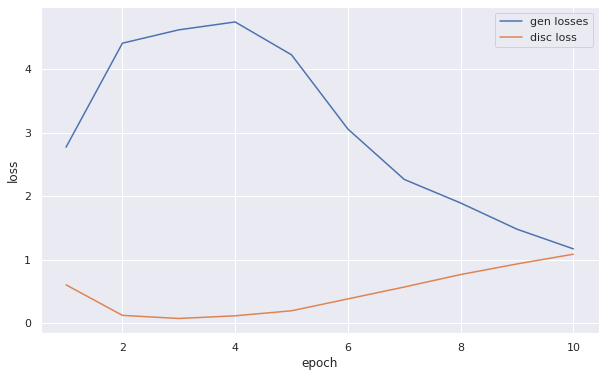

In [25]:
x_ticks = list(range(1, EPOCHS + 1))
plt.figure(figsize=(10,6))
plt.plot(x_ticks,genlosses)
plt.plot(x_ticks,disc_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['gen losses','disc loss'], loc='upper right')
plt.savefig('generator loss - discriminator loss - non vpn - {} epochs.png'.format(EPOCHS))
plt.show()

In [26]:
# helper function for generating fake samples
def generate_samples(model, num_examples_to_generate, Class):

  labels = np.full((num_examples_to_generate,), Class)

  seed = tf.random.normal([num_examples_to_generate,noise_dim])

  one_hot_encoded_labels = get_one_hot_encoding(labels, depth=7)

  gen_input = get_input_with_labels(seed, one_hot_encoded_labels)
  # gen_input_2 = get_input_with_labels(random_samples, one_hot_encoded_labels)

  # model is refering generator
  synthetic_samples = model( gen_input, training = False)

  return synthetic_samples, labels, one_hot_encoded_labels

In [27]:
# generate fake samples as follows --->
## 2500 fake chat flows
## 2500 fake email flows
## 2500 file_transfer flows

synthetic_samples_2,synthetic_labels_2, one_hot_encoded_labels = generate_samples(
    generator,
   num_examples_to_generate=2500, Class=2) # chat

synthetic_samples_3,synthetic_labels_3, one_hot_encoded_labels = generate_samples(
    generator,
   num_examples_to_generate=2500, Class=3) # email

synthetic_samples_4,synthetic_labels_4, one_hot_encoded_labels = generate_samples(
    generator,
   num_examples_to_generate=2500, Class=4) # file_transfer

## Add the generated samples to the original training data set

In [28]:
augmented_x_train = np.concatenate(( x_train, synthetic_samples_2, synthetic_samples_3,synthetic_samples_4), axis=0)
augmented_y_train = np.concatenate(( y_train, synthetic_labels_2, synthetic_labels_3,synthetic_labels_4 ), axis=0)

## Re-run Grid Search with 5-fold cross validation using a Decision Tree Classifier

In [29]:
dt = DecisionTreeClassifier()

gridSearchDT = GridSearchCV(estimator=dt,
            param_grid={'max_depth':list(range(2,31))},
        cv=StratifiedKFold(n_splits=5),
      scoring='accuracy')

gridSearchDT.fit(augmented_x_train, augmented_y_train)

print( 'best cross-validation score = {}'.format( gridSearchDT.best_score_ ) )
print( 'best params', gridSearchDT.best_params_ )

best cross-validation score = 0.698768228929471
best params {'max_depth': 17}


## Print Classification report for test set
## plot the confusion matrix

accuracy = 0.7305153931255484

Recall for P2P = 0.7531645569620253, and precision = 0.8814814814814815
Recall for audio = 0.9776444028412532, and precision = 0.7312904155854854
Recall for chat = 0.32181069958847736, and precision = 0.7947154471544715
Recall for email = 0.29528535980148884, and precision = 0.8913857677902621
Recall for file_transfer = 0.05577841451766953, and precision = 0.5615384615384615
Recall for tor = 0.5, and precision = 0.4583333333333333
Recall for video = 0.5568181818181818, and precision = 0.6915322580645161



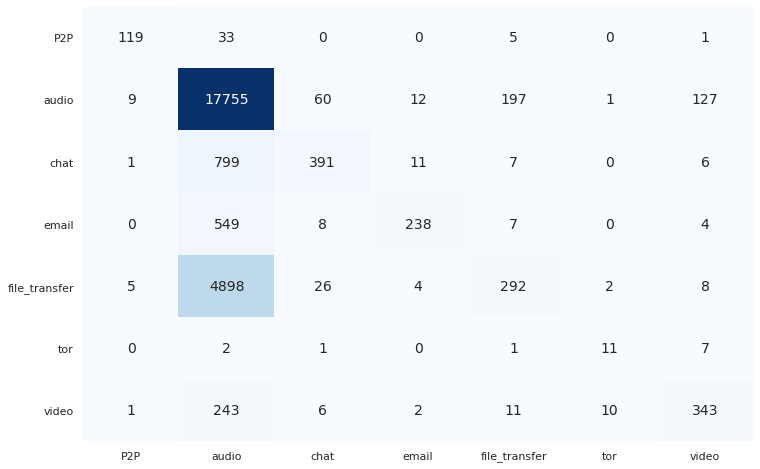

In [30]:
# print different metrics for the test set

# scores ----> accuracy, recall, precision, roc_auc, confusion matrix

best_estimator_ = gridSearchDT.best_estimator_

y_pred = best_estimator_.predict( x_test )

# recall: model's ability to detect all positive examples
recall = recall_score(y_test, y_pred, average=None)

# precision: model's ability not to classifiy as positive a negative sample
precision = precision_score(y_test, y_pred, average=None)

# accuracy
print( 'accuracy = {}\n'.format( accuracy_score( y_test, y_pred ) ) )

for i in range(n_classes):
  label = number_to_text[i]
  class_recall = recall[i]
  class_precision = precision[i]

  print('Recall for {} = {}, and precision = {}{}'.format(label, class_recall, class_precision,'\n' * ((i+1) // n_classes)))

# Create a new axes
plt.figure(figsize=(12,8))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred,labels=best_estimator_.classes_)

# Createa a heatmap for the Confusion Matrix
sns.heatmap(cm,
            annot=True,
            xticklabels=lables_text,
            yticklabels=lables_text,
            fmt='d',
            cmap=plt.cm.Blues,
            annot_kws={"size": 14},
            cbar=False)